## Decision Tree

In [197]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

#sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc, plot_roc_curve, roc_auc_score, plot_confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate


from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier

from sklearn import tree

#from util import evaluate_model

In [198]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss, confusion_matrix, plot_confusion_matrix, f1_score

def evaluate_model(model, X, y, plot_cf):
    '''
    Docstring here
    '''
    y_preds = model.predict(X)
    acc_score = accuracy_score(y, y_preds)
    precision = precision_score(y, y_preds)
    recall = recall_score(y, y_preds)
    f1 = f1_score(y, y_preds)
    print(f"Accuracy: {acc_score:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    if plot_cf == True:
        plot_confusion_matrix(model, X, y)
    return acc_score, precision, recall, f1


def model_evaluation(model_name, roc=True):
    for i, item in enumerate([(X_train, y_train), (X_test, y_test)]):
        if i == 0:
            print("Train results")
        else:
            print("Test results")

        acc, prec, rec, f1 = evaluate_model(model_name, item[0], item[1], plot_cf=True)
    
    if roc==True: 
        # Make predictions using test set 
        y_pred = model_name.predict(X_test)

        # Check the AUC of predictions
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        print('roc_auc:', roc_auc)

        plot_roc_curve(model_name, X_test, y_test);

In [199]:
df = pd.read_csv('df.csv')

In [200]:
#Train/Test/Split

X = df.drop(columns='threatened')
y = df['threatened']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33, 
                                                    random_state=42, 
                                                    stratify=y)

# Simple Tree

In [10]:
#instantiate
simple_dt = DecisionTreeClassifier(random_state=42)

#fit
simple_dt.fit(X_train, y_train)

#cross val
simple_dt_cv = cross_validate(simple_dt, X_train, y_train)
simple_dt_cv['test_score']

array([0.89727626, 0.89416342, 0.8848249 , 0.89961089, 0.89018692])

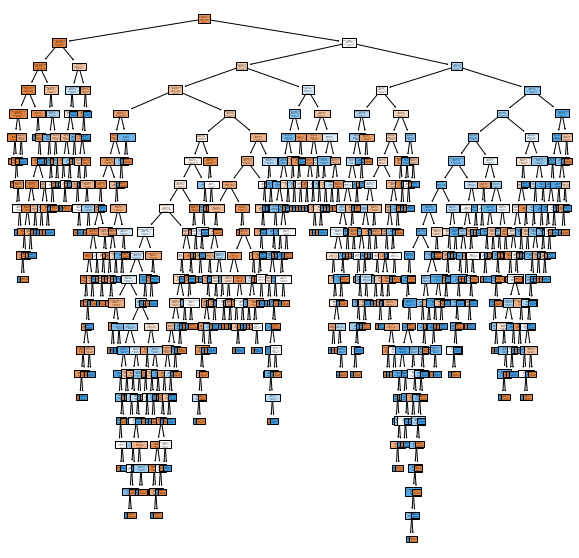

In [11]:
#Plot Tree
fig, axes = plt.subplots(figsize = (10, 10))

tree.plot_tree(simple_dt, 
               feature_names = X.columns, 
               class_names= np.unique(y).astype('str'), 
               filled = True)

plt.show();

Train results
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Test results
Accuracy: 0.8869
Precision: 0.5620
Recall: 0.5648
F1 Score: 0.5634
roc_auc: 0.749740064797499


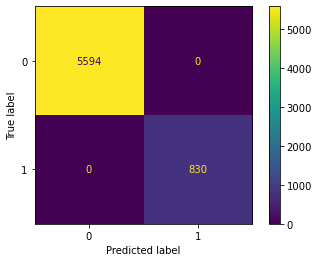

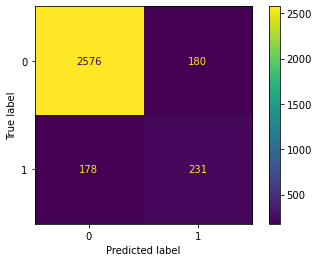

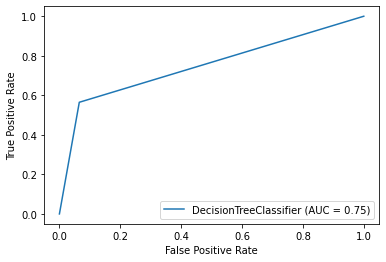

In [19]:
model_evaluation(simple_dt, roc=True)

# `max_depth`

CV Score:
[0.89494163 0.89805447 0.90038911 0.91284047 0.91433022]
Train results
Accuracy: 0.9851
Precision: 0.9576
Recall: 0.9253
F1 Score: 0.9412
Test results
Accuracy: 0.8904
Precision: 0.5775
Recall: 0.5648
F1 Score: 0.5711
roc_auc: 0.7517357106610694


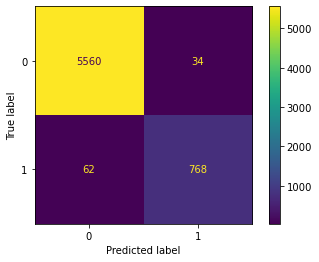

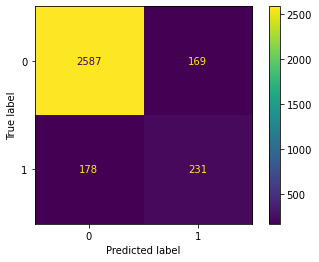

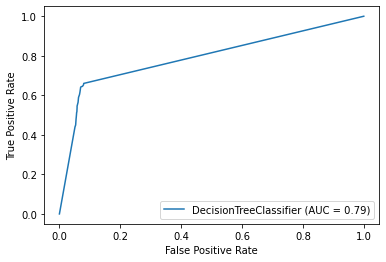

In [20]:
dt_md = DecisionTreeClassifier(random_state=42, 
                               criterion='entropy', 
                               max_depth=15)
    
#fit
dt_md.fit(X_train, y_train)

#cross val
dt_md_cv = cross_validate(dt_md, X_train, y_train)
print('CV Score:')
print(dt_md_cv['test_score']) 

model_evaluation(dt_md, roc=True)

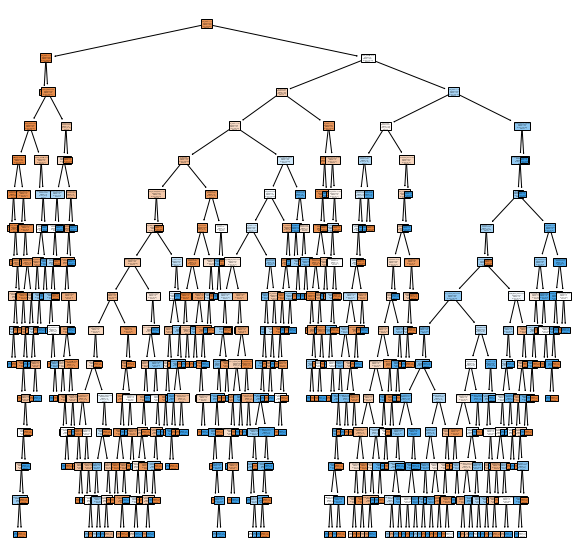

In [21]:
fig, axes = plt.subplots(figsize = (10, 10))

tree.plot_tree(dt_md, 
               feature_names = X.columns, 
               class_names= np.unique(y).astype('str'), 
               filled = True)

plt.show();

15 depths is less than the original 24 of the simple model. To be sure that the model is not overfitting, iterate over depths to find the optimal depth. 

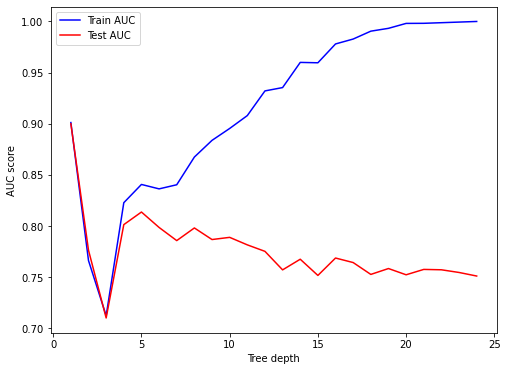

In [22]:
# Identify the optimal tree depth for given data
max_depths = np.linspace(1, 24, 24, endpoint=True)
train_results = []
test_results = []

for max_depth in max_depths:
    dt = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=42)
    dt.fit(X_train, y_train)

    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

plt.figure(figsize=(8, 6))
plt.plot(max_depths, train_results, 'b', label='Train AUC')
plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.legend()
plt.show()


## `min_samples_split`

[0.1        0.11052632 0.12105263 0.13157895 0.14210526 0.15263158
 0.16315789 0.17368421 0.18421053 0.19473684 0.20526316 0.21578947
 0.22631579 0.23684211 0.24736842 0.25789474 0.26842105 0.27894737
 0.28947368 0.3       ]


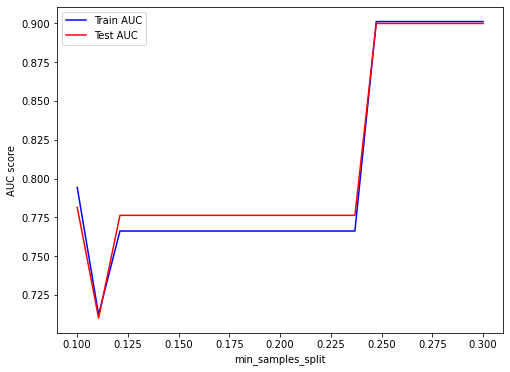

In [29]:
#mix_sample_split
min_samples_split = np.linspace(0.1, 0.3, 20, endpoint=True)
train_results = []
test_results = []


#iterate through split sizes
for x in min_samples_split:
    dt = DecisionTreeClassifier(criterion='entropy', min_samples_split=x, random_state=42)
    dt.fit(X_train, y_train)

    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

#plot AUC
plt.figure(figsize=(8, 6))
plt.plot(min_samples_split, train_results, 'b', label='Train AUC')
plt.plot(min_samples_split, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('min_samples_split')
plt.legend()
plt.show()


## `min_samples_split`

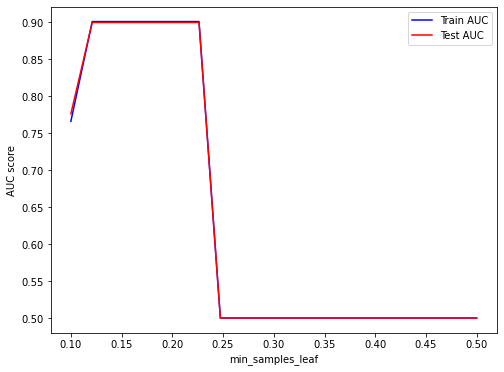

In [30]:
#leafs
min_samples_leaf = np.linspace(0.1, 0.5, 20, endpoint=True)
train_results = []
test_results = []

for x in min_samples_leaf:
    dt = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=x, random_state=42)
    dt.fit(X_train, y_train)

    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

plt.figure(figsize=(8, 6))
plt.plot(min_samples_leaf, train_results, 'b', label='Train AUC')
plt.plot(min_samples_leaf, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('min_samples_leaf')
plt.legend()
plt.show()


## `class_weight`

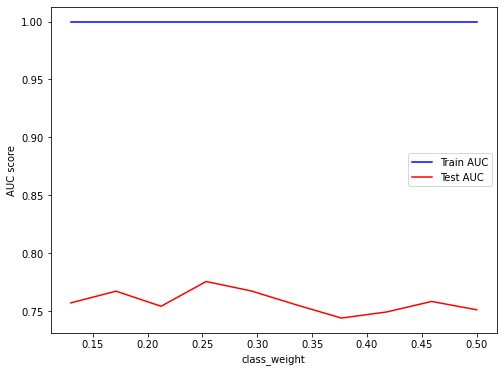

In [48]:
#leafs
weights = np.linspace(0.13, 0.50, 10)
class_weight = [{1: x, 0: 1.0-x} for x in weights]

train_results = []
test_results = []

for x in class_weight:
    dt = DecisionTreeClassifier(criterion='entropy', class_weight=x, random_state=42)
    dt.fit(X_train, y_train)

    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

plt.figure(figsize=(8, 6))
plt.plot(weights, train_results, 'b', label='Train AUC')
plt.plot(weights, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('class_weight')
plt.legend()
plt.show()

Train results
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Test results
Accuracy: 0.8942
Precision: 0.5845
Recall: 0.6259
F1 Score: 0.6045
roc_auc: 0.7799395672832957


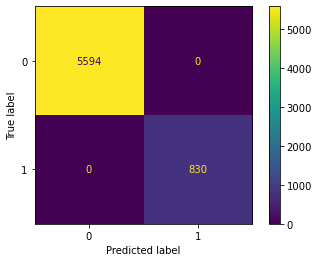

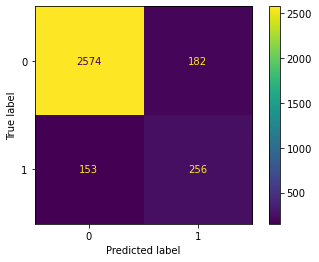

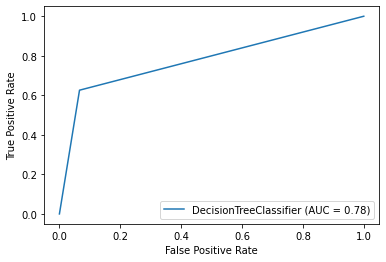

In [32]:
#class_weight
dt_bal = DecisionTreeClassifier(criterion='entropy', class_weight='balanced', random_state=42)
dt_bal.fit(X_train, y_train)

model_evaluation(dt_bal, roc=True)

# Tuning based on above

In [38]:
model = DecisionTreeClassifier(criterion='entropy', 
                               max_depth= 6, 
                               min_samples_split= 0.25, 
                               min_samples_leaf = 0.15)

model.fit(X_train, y_train)

model_cv = cross_validate(model, X_train, y_train)
print('CV test_score:', model_cv['test_score'])

CV test_score: [0.8770428  0.87782101 0.85447471 0.87548638 0.88239875]


Train results
Accuracy: 0.8734
Precision: 0.5055
Recall: 0.9386
F1 Score: 0.6571
Test results
Accuracy: 0.8638
Precision: 0.4862
Recall: 0.9487
F1 Score: 0.6429
roc_auc: 0.8999444643560527


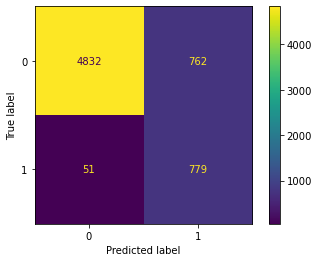

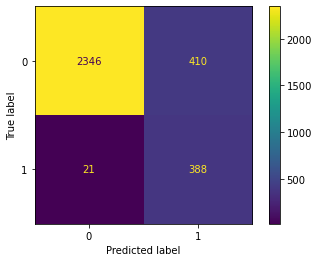

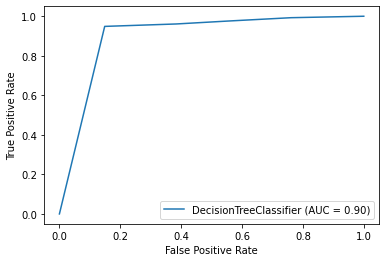

In [39]:
model_evaluation(model, roc=True)

# Grid Search

In [61]:
clf = DecisionTreeClassifier(random_state=42)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2, 5, 10],
    'min_samples_split': [0.05, 0.1, 0.25, 0.5], 
    
}

gs_tree = GridSearchCV(clf, param_grid, cv=3)
gs_tree.fit(X_train, y_train)

gs_tree.best_params_

{'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 0.1}

### model_gs

Train results
Accuracy: 0.9080
Precision: 0.6653
Recall: 0.5795
F1 Score: 0.6194
Test results
Accuracy: 0.8995
Precision: 0.6194
Recall: 0.5770
F1 Score: 0.5975


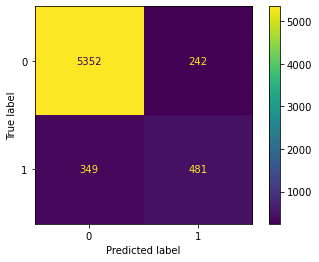

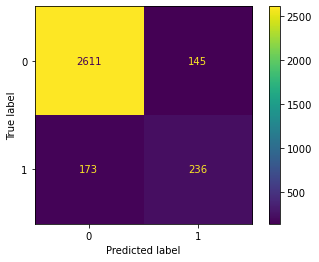

In [63]:
model_gs = DecisionTreeClassifier(criterion = 'gini',
                                  max_depth = 5,
                                  min_samples_split = 0.1, 
                                  random_state = 42)

model_gs.fit(X_train, y_train)

model_gs_cv = cross_validate(model_gs, X_train, y_train, cv=5)

model_evaluation(model_gs, roc=False)

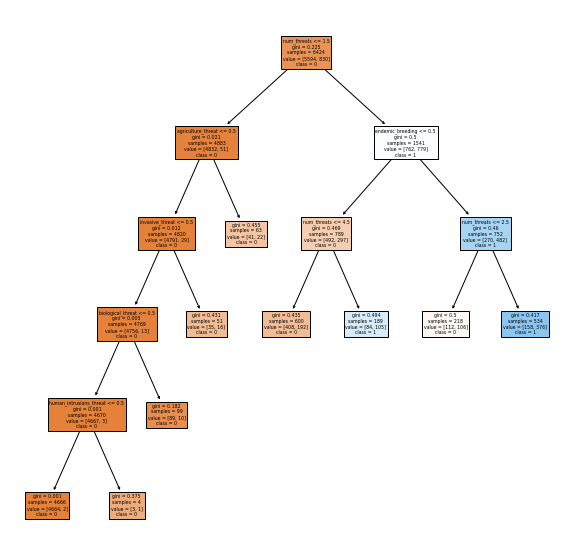

In [64]:
fig, axes = plt.subplots(figsize = (10, 10))

tree.plot_tree(model_gs, 
               feature_names = X.columns, 
               class_names= np.unique(y).astype('str'), 
               filled = True)

plt.show();

In [84]:
m_gs_features = dict(zip(X_train.columns, model_gs.feature_importances_))

pd.DataFrame.from_dict(m_gs_features, orient='index').sort_values(by=0, ascending=False).head(15)

,0
num_threats,0.882220
endemic_breeding,0.078600
agriculture_threat,0.021367
invasive_threat,0.014238
biological_threat,0.002849
human_intrusions_threat,0.000726
x0_Passeriformes,0.000000
x0_Nonpasseriformes,0.000000
x1_PlantSeed,0.000000
x1_Omnivore,0.000000


### model2

Train results
Accuracy: 0.8750
Precision: 0.5084
Recall: 0.9831
F1 Score: 0.6702
Test results
Accuracy: 0.8670
Precision: 0.4926
Recall: 0.9829
F1 Score: 0.6563


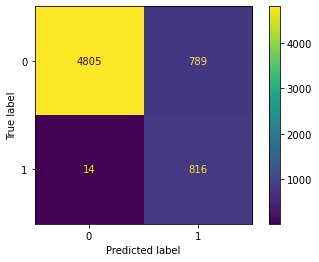

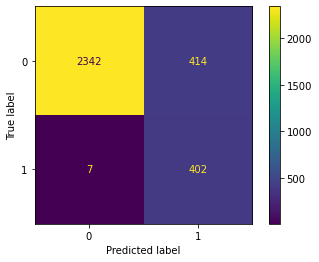

In [85]:
#class weight = balanced
model2 = DecisionTreeClassifier(criterion = 'gini',
                                  max_depth = 20,
                                  min_samples_split = 0.05, 
                                  class_weight='balanced', 
                                  random_state = 42)

model2.fit(X_train, y_train)

model2_cv = cross_validate(model2, X_train, y_train, cv=5)

model_evaluation(model2, roc=False)

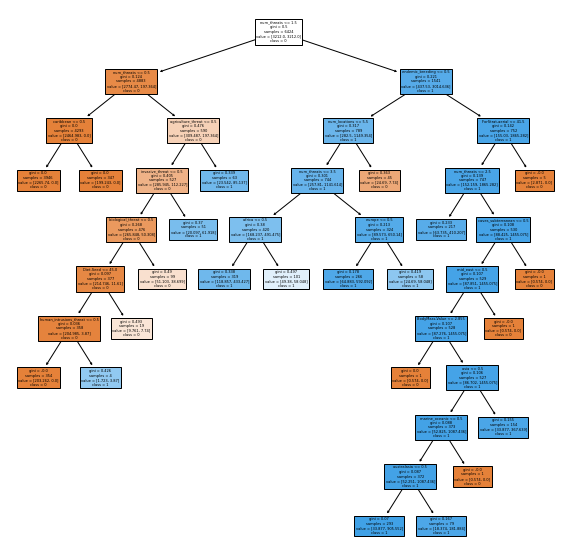

In [67]:
fig, axes = plt.subplots(figsize = (10, 10))

tree.plot_tree(model2, 
               feature_names = X.columns, 
               class_names= np.unique(y).astype('str'), 
               filled = True)

plt.show();

In [80]:
#important features
m2_features = dict(zip(X_train.columns, model2.feature_importances_))

pd.DataFrame.from_dict(m2_features, orient='index').sort_values(by=0, ascending=False).head(15)

,0
num_threats,0.920630
invasive_threat,0.019144
agriculture_threat,0.017782
endemic_breeding,0.010085
num_locations,0.008741
biological_threat,0.007673
africa,0.004450
europe,0.002425
Diet-Seed,0.002401
human_intrusions_threat,0.002158


# Grid Search 2 - scoring = 'accuracy'
* Honing in on best class weights
* adjust scoring accuracy

In [21]:
##elements for grid parameters

#simple_dt_depth = simple_dt.get_depth()

#get 'min_samples_split' list
s = 0.0025
s_list = [0.0025]     
while s<0.5: 
    s *=2
    s_list.append(s)
s_list.pop()

#class_weights list
weights = np.linspace(0.13, 0.50, 10)
class_weight = [{1: x, 0: 1.0-x} for x in weights]
class_weight

[{1: 0.13, 0: 0.87},
 {1: 0.1711111111111111, 0: 0.8288888888888889},
 {1: 0.21222222222222223, 0: 0.7877777777777778},
 {1: 0.25333333333333335, 0: 0.7466666666666666},
 {1: 0.29444444444444445, 0: 0.7055555555555555},
 {1: 0.33555555555555555, 0: 0.6644444444444444},
 {1: 0.3766666666666667, 0: 0.6233333333333333},
 {1: 0.4177777777777778, 0: 0.5822222222222222},
 {1: 0.4588888888888889, 0: 0.5411111111111111},
 {1: 0.5, 0: 0.5}]

In [88]:
clf = DecisionTreeClassifier(random_state=42)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter' : ['best', 'random'], 
    'min_samples_split': s_list,
    'max_depth': [d for d in range(4, 12)], 
    'class_weight': class_weight
}

gs_tree_2 = GridSearchCV(estimator=clf, 
                         param_grid=param_grid, 
                         scoring='accuracy',
                         cv=5)

gs_tree_2.fit(X_train, y_train)

print(f'best_params:', gs_tree_2.best_params_)

best_params: {'class_weight': {1: 0.5, 0: 0.5}, 'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 0.02, 'splitter': 'random'}


### model_gs2

CV test_score: [0.90661479 0.91906615 0.91284047 0.90428016 0.91588785]
Train results
Accuracy: 0.9189
Precision: 0.7210
Recall: 0.6072
F1 Score: 0.6593
Test results
Accuracy: 0.9087
Precision: 0.6818
Recall: 0.5501
F1 Score: 0.6089


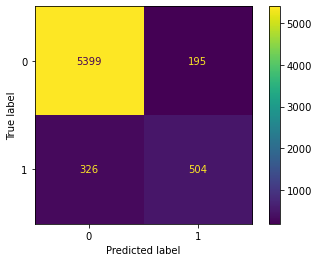

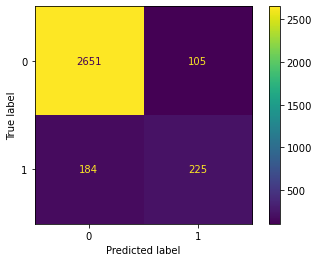

In [92]:
#tuned down class_we
model_gs2 = DecisionTreeClassifier(random_state=42, 
                                   class_weight={0:1, 0:1},
                                   criterion='gini',
                                   max_depth=7, 
                                   min_samples_split=0.02, 
                                   splitter='random')

model_gs2.fit(X_train, y_train)

model_gs2_cv = cross_validate(model_gs2, X_train, y_train, cv=5)
print(f'CV test_score:', model_gs2_cv['test_score'])

model_evaluation(model_gs2, roc=False)

CV test_score: [0.86303502 0.87392996 0.84280156 0.88015564 0.87461059]
Train results
Accuracy: 0.8750
Precision: 0.5084
Recall: 0.9819
F1 Score: 0.6700
Test results
Accuracy: 0.8619
Precision: 0.4824
Recall: 0.9389
F1 Score: 0.6373


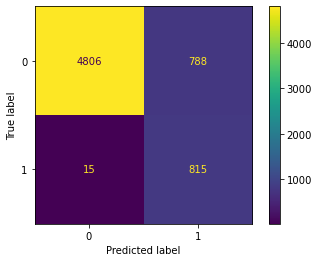

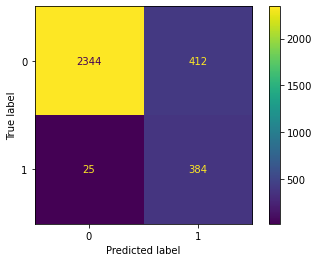

In [94]:
#same as above with class_weights 'balanced'

model_bal = DecisionTreeClassifier(random_state=42, 
                                   class_weight='balanced',
                                   criterion='gini',
                                   max_depth=7, 
                                   min_samples_split=0.02, 
                                   splitter='random')

model_bal.fit(X_train, y_train)

model_bal_cv = cross_validate(model_bal, X_train, y_train, cv=5)
print(f'CV test_score:', model_bal_cv['test_score'])

model_evaluation(model_bal, roc=False)

### model4

CV test_score: [0.89961089 0.91595331 0.90505837 0.90894942 0.91666667]
Train results
Accuracy: 0.9180
Precision: 0.7371
Recall: 0.5675
F1 Score: 0.6413
Test results
Accuracy: 0.9030
Precision: 0.6527
Recall: 0.5330
F1 Score: 0.5868


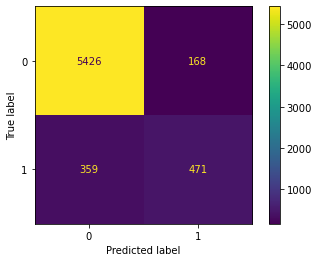

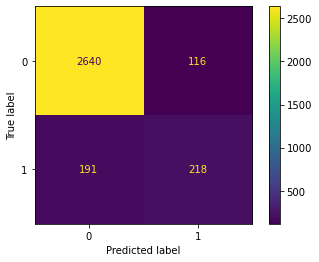

In [132]:
#class_weight turned down
model4 = DecisionTreeClassifier(random_state=42, 
                                class_weight={0:5, 1:4}, 
                                criterion='gini',
                                max_depth=7, 
                                min_samples_split=0.02, 
                                splitter='random')

model4.fit(X_train, y_train)

model4_cv = cross_validate(model4, X_train, y_train, cv=5)
print(f'CV test_score:', model4_cv['test_score'])

model_evaluation(model4, roc=False)

### model5
* combining 'balance' and fewer min_samples_leaf since they seem to produce the strongest when manipulated separately

CV test_score: [0.88015564 0.88093385 0.85836576 0.89338521 0.88551402]
Train results
Accuracy: 0.8949
Precision: 0.5520
Recall: 0.9904
F1 Score: 0.7089
Test results
Accuracy: 0.8701
Precision: 0.4987
Recall: 0.9193
F1 Score: 0.6466


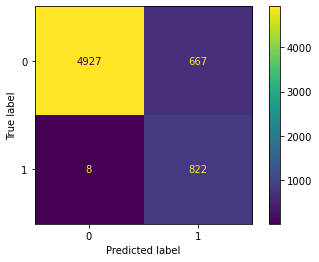

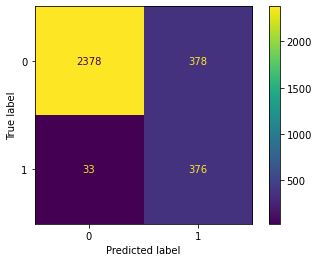

In [8]:
model5 = DecisionTreeClassifier(random_state=42, 
                                class_weight='balanced', 
                                criterion='gini',
                                max_depth=7,
                                min_samples_leaf=0.001,
                                splitter='best')

model5.fit(X_train, y_train)

model5_cv = cross_validate(model5, X_train, y_train, cv=5)
print(f'CV test_score:', model5_cv['test_score'])

model_evaluation(model5, roc=False)

In [144]:
#important features
m5_features = dict(zip(X_train.columns, model5.feature_importances_))

pd.DataFrame.from_dict(m5_features, orient='index').sort_values(by=0, ascending=False).head(15)

,0
num_threats,0.878350
invasive_threat,0.018184
endemic_breeding,0.018114
agriculture_threat,0.016890
num_locations,0.008303
biological_threat,0.007289
BodyMass-Value,0.006266
ForStrat-midhigh,0.005416
Diet-Seed,0.005206
africa,0.004227


# GridSearch 3
* scoring='recall'

In [24]:
clf = DecisionTreeClassifier(random_state=42)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter' : ['best', 'random'], 
    'min_samples_split': [0.0025, 0.005, 0.01, 0.02, 0.04, 0.08, 0.16, 0.32],
    'max_depth': [d for d in range(4, 12)], 
    'class_weight': [{1: 0.13, 0: 0.87},
                     {1: 1, 0: 4},
                     {1: 2, 0: 3},
                     {1: 0.3, 0: 0.7},
                     {1: 0.4, 0: 0.5},
                     {1: 0.45, 0: 0.55},
                     {1: 1, 0: 1}, 'balanced']
}

gs_tree_3 = GridSearchCV(estimator=clf, 
                         param_grid=param_grid, 
                         scoring='recall',
                         cv=3)

gs_tree_3.fit(X_train, y_train)

print(f'best_params:', gs_tree_3.best_params_)
#best_params: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 0.04, 'splitter': 'random'}

best_params: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 0.04, 'splitter': 'random'}


CV test_score: [0.85680934 0.85914397 0.83579767 0.86536965 0.86292835]
Train results
Accuracy: 0.8566
Precision: 0.4739
Recall: 0.9952
F1 Score: 0.6421
Test results
Accuracy: 0.8515
Precision: 0.4652
Recall: 0.9976
F1 Score: 0.6345


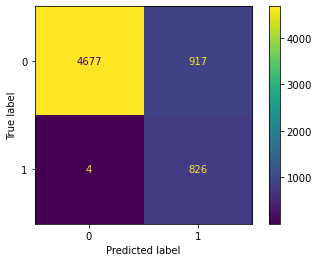

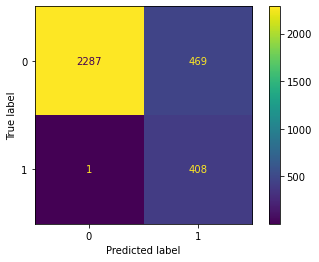

In [152]:
gs_tree_3 = DecisionTreeClassifier(random_state=42, 
                                   class_weight='balanced', 
                                   criterion = 'gini', 
                                   max_depth=4, 
                                   min_samples_split=0.04, 
                                   splitter='random')

gs_tree_3.fit(X_train, y_train)

gs_tree_3_cv = cross_validate(gs_tree_3, X_train, y_train, cv=5)
print(f'CV test_score:', gs_tree_3_cv['test_score'])

model_evaluation(gs_tree_3, roc=False)

In [32]:
gs3_features = dict(zip(X_train.columns, gs_tree_2.feature_importances_))
pd.DataFrame.from_dict(gs3_features, orient='index').sort_values(by=0, ascending=False).head(15)

,0
agriculture_threat,0.620635
invasive_threat,0.269691
biological_threat,0.085022
endemic_breeding,0.008111
europe,0.005771
climate_change_threat,0.004234
natural_systems_threat,0.003382
Diet-Inv,0.002601
australasia,0.000553
rocky_areas,0.000000


# Bagged Decision Trees

In [69]:
# define models and parameters
model = BaggingClassifier()
n_estimators = [10, 100, 1000]

# define grid search
grid = dict(n_estimators=n_estimators)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.912465 using {'n_estimators': 1000}
0.905250 (0.008644) with: {'n_estimators': 10}
0.912257 (0.009526) with: {'n_estimators': 100}
0.912465 (0.008581) with: {'n_estimators': 1000}


# XGBoost Trees

In [40]:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree

C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:47:44] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train results
Accuracy: 0.9983
Precision: 0.9976
Recall: 0.9892
F1 Score: 0.9933
Test results
Accuracy: 0.9036
Precision: 0.6307
Recall: 0.6137
F1 Score: 0.6221
roc_auc: 0.7801768801388215


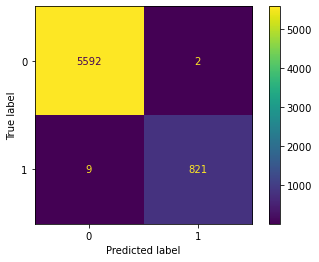

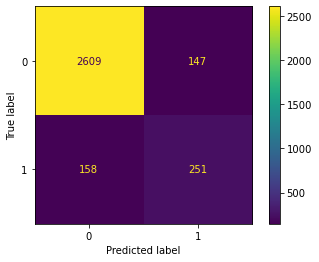

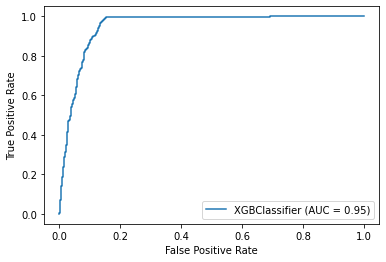

In [38]:
xgb_clf = XGBClassifier(random_state=42)

xgb_clf.fit(X_train, y_train)

model_evaluation(xgb_clf)

[11:00:59] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train results
Accuracy: 0.9413
Precision: 0.7726
Recall: 0.7735
F1 Score: 0.7730
Test results
Accuracy: 0.9074
Precision: 0.6472
Recall: 0.6235
F1 Score: 0.6351


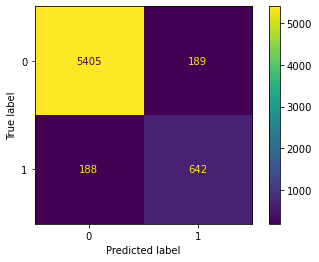

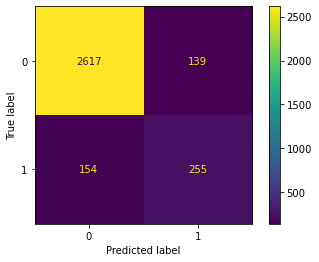

In [47]:
xgb_clf_2 = XGBClassifier(random_state=42, 
                        sampling_method="gradient_based",
                        max_depth=4, 
                        eta=0.1, 
                        use_label_encoder=False)

xgb_clf_2.fit(X_train, y_train)

model_evaluation(xgb_clf_2, roc=False)

[11:05:13] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train results
Accuracy: 0.9986
Precision: 0.9964
Recall: 0.9928
F1 Score: 0.9946
Test results
Accuracy: 0.9058
Precision: 0.6412
Recall: 0.6161
F1 Score: 0.6284


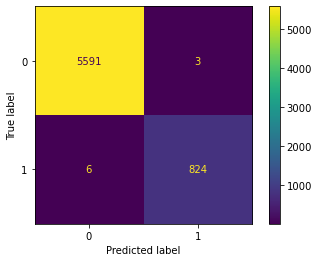

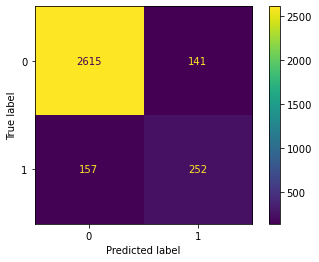

In [49]:
xgb_clf_tree = XGBClassifier(random_state=42, 
                             tree_method='hist', 
                             use_label_encoder=False)

xgb_clf_tree.fit(X_train, y_train)

model_evaluation(xgb_clf_tree, roc=False)

[11:08:40] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train results
Accuracy: 0.9983
Precision: 0.9976
Recall: 0.9892
F1 Score: 0.9933
Test results
Accuracy: 0.9036
Precision: 0.6307
Recall: 0.6137
F1 Score: 0.6221


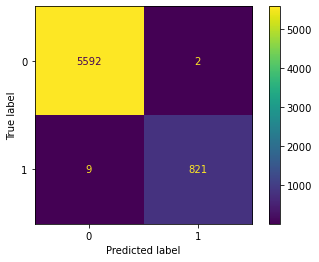

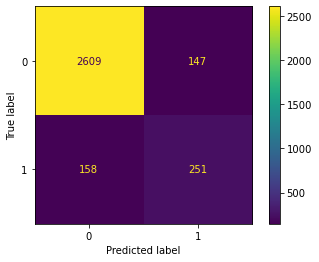

In [50]:
xgb_clf_dart = XGBClassifier(random_state=42, 
                              booster='dart', 
                              use_label_encoder=False)

xgb_clf_dart.fit(X_train, y_train)

model_evaluation(xgb_clf_dart, roc=False)

GridSearch of XGBoost

In [65]:
xgb = XGBClassifier(random_state=42)

param_grid = {
    'learning_rate':[0.05, 0.1, 0.2], 
    'max_depth': [4, 6, 8],
    'n_estimators': [50, 100],
    'tree_method': ['auto', 'hist'],
    'process_type': ['default', 'update'], 
    'subsample': [0.5, 0.25], 
    'use_label_encoder':[False]}


gs_xgb = GridSearchCV(estimator=xgb, 
                         param_grid=param_grid, 
                         scoring='recall',
                         cv=3)

gs_xgb.fit(X_train, y_train)

print(f'best_params:', gs_xgb.best_params_)

[11:32:15] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:15] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:15] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:16] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 909, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 227, in train
    bst = _train_internal(params, dtrain,
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 102, in _train_inter

[11:32:18] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:19] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:19] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:19] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 909, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 227, in train
    bst = _train_internal(params, dtrain,
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 102, in _train_inter

[11:32:21] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:22] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:22] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:22] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 909, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 227, in train
    bst = _train_internal(params, dtrain,
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 102, in _train_inter

[11:32:24] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:24] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:25] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:25] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 909, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 227, in train
    bst = _train_internal(params, dtrain,
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 102, in _train_inter

[11:32:28] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:28] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:28] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:28] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 909, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 227, in train
    bst = _train_internal(params, dtrain,
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 102, in _train_inter

[11:32:30] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:31] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:31] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:32] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 909, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 227, in train
    bst = _train_internal(params, dtrain,
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 102, in _train_inter

[11:32:34] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:35] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:35] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:35] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 909, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 227, in train
    bst = _train_internal(params, dtrain,
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 102, in _train_inter

[11:32:36] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:37] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:37] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:37] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 909, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 227, in train
    bst = _train_internal(params, dtrain,
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 102, in _train_inter

[11:32:40] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:40] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:40] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:40] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 909, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 227, in train
    bst = _train_internal(params, dtrain,
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 102, in _train_inter

[11:32:42] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:42] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:43] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:43] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 909, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 227, in train
    bst = _train_internal(params, dtrain,
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 102, in _train_inter

[11:32:46] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:46] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:46] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:47] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 909, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 227, in train
    bst = _train_internal(params, dtrain,
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 102, in _train_inter

[11:32:48] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:49] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:49] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:50] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 909, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 227, in train
    bst = _train_internal(params, dtrain,
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 102, in _train_inter

[11:32:53] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:53] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:53] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:53] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 909, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 227, in train
    bst = _train_internal(params, dtrain,
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 102, in _train_inter

[11:32:55] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:55] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:55] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:56] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 909, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 227, in train
    bst = _train_internal(params, dtrain,
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 102, in _train_inter

[11:32:58] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:58] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:58] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:32:59] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 909, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 227, in train
    bst = _train_internal(params, dtrain,
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 102, in _train_inter

[11:33:00] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:33:01] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:33:01] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:33:02] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 909, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 227, in train
    bst = _train_internal(params, dtrain,
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 102, in _train_inter

[11:33:04] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:33:05] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:33:05] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:33:05] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 909, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 227, in train
    bst = _train_internal(params, dtrain,
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 102, in _train_inter

[11:33:07] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:33:07] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:33:08] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:33:08] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\core.py", line 422, in inner_f
    return f(**kwargs)
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py", line 909, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 227, in train
    bst = _train_internal(params, dtrain,
  File "C:\Users\cryst\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py", line 102, in _train_inter

[11:33:11] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
best_params: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 50, 'process_type': 'default', 'subsample': 0.5, 'tree_method': 'auto', 'use_label_encoder': False}


In [ ]:
#best_params: {'learning_rate': 0.05, 'max_depth': 6, 
#'n_estimators': 50, 'process_type': 'default', 'subsample': 0.5, 
#'tree_method': 'auto', 'use_label_encoder': False}

Train results
Accuracy: 0.9443
Precision: 0.7803
Recall: 0.7916
F1 Score: 0.7859
Test results
Accuracy: 0.9106
Precision: 0.6529
Recall: 0.6577
F1 Score: 0.6553


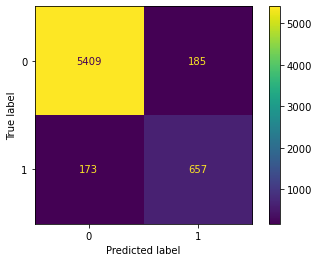

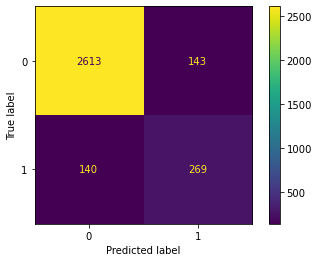

In [68]:
model_evaluation(gs_xgb, roc=False)

[11:40:02] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:40:03] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:40:03] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:40:03] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

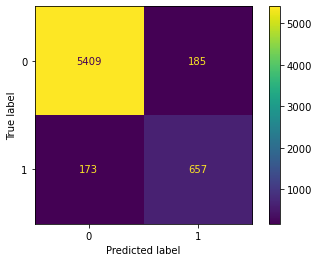

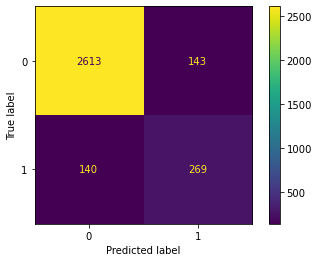

In [71]:
#{'learning_rate': 0.05, 'max_depth': 6, 
#'n_estimators': 50, 'process_type': 'default', 'subsample': 0.5, 
#'tree_method': 'auto', 'use_label_encoder': False}
 
xgb = XGBClassifier(random_state=42, 
                    learning_rate= 0.05, 
                    max_depth = 6, 
                    n_estimators = 50, 
                    process_type= 'default', 
                    subsample=0.5, 
                    use_label_encoder = False)

xgb.fit(X_train, y_train)

xgb_cv = cross_validate(xgb, X_train, y_train, cv=3)
print(f'CV test_score:', xgb_cv['test_score'])

model_evaluation(xgb, roc=False)

In [ ]:
predict_proba

In [72]:
#important features
xgb_features = dict(zip(X_train.columns, xgb.feature_importances_))

pd.DataFrame.from_dict(xgb_features, orient='index').sort_values(by=0, ascending=False).head(15)

,0
num_threats,0.256437
mid_east,0.038741
endemic_breeding,0.032902
num_locations,0.024948
agriculture_threat,0.022608
europe,0.021247
climate_change_threat,0.017379
artificial_aquatic,0.016617
transportation_threat,0.016283
invasive_threat,0.015866


# CatBoost

In [77]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(
    iterations=5,
    learning_rate=0.1,
    loss_function='CrossEntropy', 
    random_state=42)

cat_model.fit(X_train, y_train) 

print('Model is fitted: ' + str(cat_model.is_fitted()))
print('Model params:')
print(cat_model.get_params())

0:	learn: 0.5414644	total: 4.98ms	remaining: 19.9ms
1:	learn: 0.4218461	total: 9.76ms	remaining: 14.6ms
2:	learn: 0.3498492	total: 13.6ms	remaining: 9.08ms
3:	learn: 0.2866633	total: 17.4ms	remaining: 4.35ms
4:	learn: 0.2631455	total: 20.7ms	remaining: 0us
Model is fitted: True
Model params:
{'iterations': 5, 'learning_rate': 0.1, 'loss_function': 'CrossEntropy', 'random_state': 42}


Train results
Accuracy: 0.9163
Precision: 0.6989
Recall: 0.6181
F1 Score: 0.6560
Test results
Accuracy: 0.9046
Precision: 0.6450
Recall: 0.5819
F1 Score: 0.6118
roc_auc: 0.7671872172206626


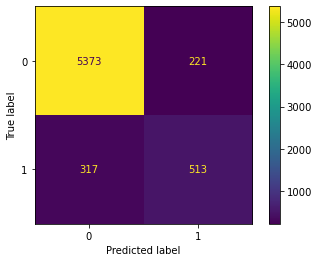

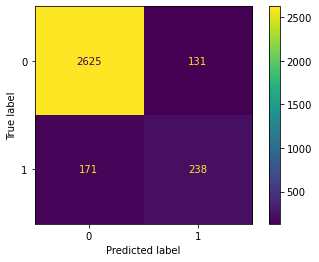

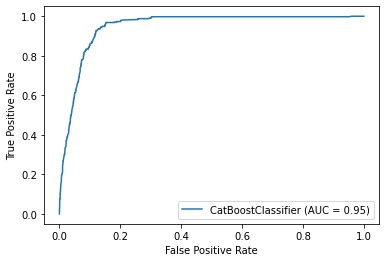

In [78]:
model_evaluation(cat_model)

0:	learn: 0.5414644	total: 13.2ms	remaining: 53ms
1:	learn: 0.4218461	total: 18ms	remaining: 27ms
2:	learn: 0.3498492	total: 21.6ms	remaining: 14.4ms
3:	learn: 0.2866633	total: 25.1ms	remaining: 6.26ms
4:	learn: 0.2631455	total: 28.6ms	remaining: 0us
Model is fitted: True
Model params:
{'iterations': 5, 'learning_rate': 0.1, 'random_state': 42}
Train results
Accuracy: 0.9163
Precision: 0.6989
Recall: 0.6181
F1 Score: 0.6560
Test results
Accuracy: 0.9046
Precision: 0.6450
Recall: 0.5819
F1 Score: 0.6118
roc_auc: 0.7671872172206626


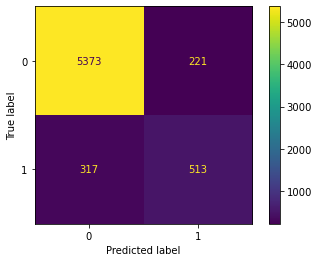

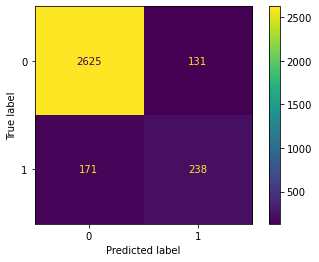

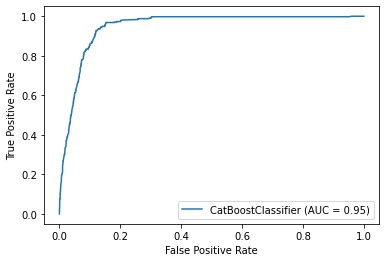

In [80]:
cat2_model = CatBoostClassifier(
    iterations=5,
    learning_rate=0.1,
    random_state=42, )

cat2_model.fit(X_train, y_train) 

print('Model is fitted: ' + str(cat2_model.is_fitted()))
print('Model params:')
print(cat2_model.get_params())

model_evaluation(cat2_model)

In [209]:
not_cat= ['Diet-Inv', 'Diet-Fish', 'Diet-Scav', 'Diet-Fruit',
          'Diet-Nect','BodyMass-Value','Diet-Seed', 'Diet-PlantO', 
          'ForStrat-watbelowsurf','ForStrat-wataroundsurf', 
          'ForStrat-ground', 'ForStrat-understory','ForStrat-midhigh', 
          'ForStrat-canopy', 'ForStrat-aerial','PelagicSpecialist', 
          'ForStrat-SpecLevel', 'Diet-PlantO','ForStrat-watbelowsurf',
          'num_habitats', 'num_threats','num_locations']

In [223]:
cat_features=[x for x in X_train.columns if x not in not_cat]

print(len(cat_features) + len(not_cat))
print(len(X_train.columns))

72
70


In [120]:
X_train[cat_features] = X_train[cat_features].astype(int).copy()

In [137]:
#body_mass = X_train['BodyMass-Value']

X_train = X_train.astype(int).copy()

#X_train['BodyMass-Value'] = body_mass
#X_train.info()

In [141]:
pd.set_option('display.max_columns', None)
X_train.head(20)

,Diet-Inv,Diet-Fish,Diet-Scav,Diet-Fruit,Diet-Nect,Diet-Seed,Diet-PlantO,ForStrat-watbelowsurf,ForStrat-wataroundsurf,ForStrat-ground,ForStrat-understory,ForStrat-midhigh,ForStrat-canopy,ForStrat-aerial,PelagicSpecialist,ForStrat-SpecLevel,Nocturnal,BodyMass-Value,endemic_breeding,migratory,africa,antarctica,asia,australasia,caribbean,central_amer,central_asia,europe,high_seas,mid_east,north_amer,oceania,south_amer,agriculture_threat,biological_threat,climate_change_threat,energy_mining_threat,geological_threat,human_intrusions_threat,natural_systems_threat,pollution_threat,res_comm_dev_threat,transportation_threat,invasive_threat,artificial_aquatic,artificial_terrestrial,caves_subterranean,desert,forest,grassland,introduced_vegetation,marine_coastal_supratidal,marine_intertidal,marine_neritic,marine_oceanic,rocky_areas,savanna,shrubland,wetlands_inland,num_habitats,num_threats,num_locations,Diet-Vertebrates,x0_Nonpasseriformes,x0_Passeriformes,x1_FruiNect,x1_Invertebrate,x1_Omnivore,x1_PlantSeed,x1_VertFishScav
9382,20,0,0,0,0,80,0,0,0,20,20,30,30,0,0,1,0,34,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,3,5,1,0,0,1,0,0,0,1,0
4394,100,0,0,0,0,0,0,0,0,10,60,30,0,0,0,1,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,4,1,0,0,1,0,1,0,0,0
7398,0,0,0,20,10,60,10,0,0,50,50,0,0,0,0,1,0,22,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0
8289,50,0,0,0,0,0,0,0,0,80,10,10,0,0,0,0,1,51,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,1,0,1,6,4,1,50,1,0,0,1,0,0,0
2938,0,0,0,0,0,0,0,0,0,100,0,0,0,0,0,1,0,2378,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,3,0,1,100,1,0,0,0,0,0,1
2495,100,0,0,0,0,0,0,0,20,80,0,0,0,0,0,1,0,196,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,3,0,1,0,1,0,0,1,0,0,0
4638,100,0,0,0,0,0,0,0,0,0,80,20,0,0,0,1,0,11,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,2,0,2,0,0,1,0,1,0,0,0
8971,100,0,0,0,0,0,0,0,0,60,40,0,0,0,0,1,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0
184,30,0,0,30,0,40,0,0,0,100,0,0,0,0,0,1,0,269,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,2,3,1,0,1,0,0,0,1,0,0
3950,100,0,0,0,0,0,0,0,0,0,20,80,0,0,0,1,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,3,1,0,0,1,0,1,0,0,0


In [144]:
X_train.replace({0: int(0)}, inplace=True)

# best model

Train results
Accuracy: 0.9328
Precision: 0.6597
Recall: 0.9914
F1 Score: 0.7923
Test results
Accuracy: 0.9003
Precision: 0.5709
Recall: 0.9226
F1 Score: 0.7053
roc_auc: 0.9098056482511432


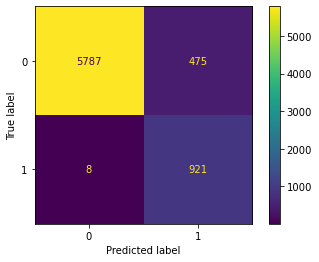

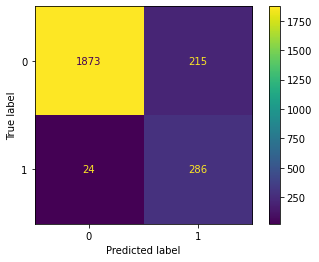

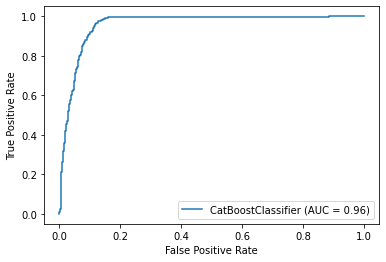

In [342]:
clf = CatBoostClassifier(
    iterations=100,
    random_seed=42,
    learning_rate=0.1,
    custom_loss='Recall', 
    max_depth = 7,
    class_weights=(1,3.5), 
    
)
#cat_features=cat_features    

clf.fit(X_train, y_train, verbose=False)

model_evaluation(clf)

In [343]:
#important features
clf_features = dict(zip(X_train.columns, clf.feature_importances_))

pd.DataFrame.from_dict(clf_features, orient='index').sort_values(by=0, ascending=False).head(20)

,0
num_threats,37.093720
endemic_breeding,8.978855
agriculture_threat,6.854127
BodyMass-Value,3.768475
num_locations,3.456801
x0_Passeriformes,3.390617
invasive_threat,2.124516
ForStrat-midhigh,1.911242
australasia,1.732463
ForStrat-ground,1.706746


Catboost Data Preparation

In [307]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [308]:
X_train=X_train.astype(int)

In [309]:
train_df = pd.concat([X_train, y_train])
test_df = pd.concat([X_test, y_test])

In [251]:
# cat_features = [14,16] + list(range(18,59)) + list(range(63,69))
# type(cat_features[0])

int

In [252]:
# for i in cat_features:
#     col_name= X_train.columns[i]
#     X_train[col_name]= X_train[col_name].astype(int)

<ipython-input-252-84341da9bd16>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col_name]= X_train[col_name].astype(int)


In [299]:
cat_features = np.array(list(range(0, (X_train.shape[1]))))

In [271]:
print(f'Labels: {set(y)}')
print(f'Zero count = {y.value_counts()[1]}')

Labels: {0, 1}
Zero count = 1239


In [286]:
from catboost.utils import create_cd

feature_names = dict()

for column, name in enumerate(X_train):
    if column == 0:
        continue
    feature_names[column - 1] = name
    
# create_cd(
#     label=0, 
#     cat_features=list(range(1, train_df.columns.shape[0])),
#     feature_names=feature_names,
#     output_path='train.cd'
# )

In [296]:
from catboost import Pool

pool1 = Pool(data=X_train, label=y_train, cat_features=cat_features)

print(f'Data shape: {pool1.shape}')

Data shape: (7191, 70)


In [ ]:
cat_features = ['agriculture_threat']

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Train results
Accuracy: 0.9154
Precision: 0.6945
Recall: 0.6168
F1 Score: 0.6534
Test results
Accuracy: 0.9133
Precision: 0.6783
Recall: 0.6258
F1 Score: 0.6510


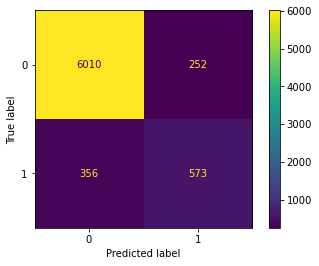

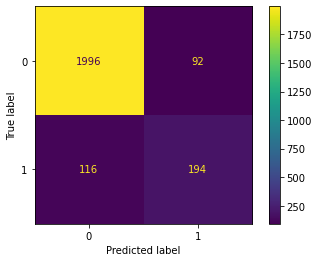

In [310]:
cat1_model = CatBoostClassifier(random_state=42, 
                           iterations=10, 
                           learning_rate=0.1)


cat1_model.fit(X_train, y_train, 
               eval_set=(X_test, y_test), 
               verbose=False,
          
               plot=True)
# cat_features=[63,64,65,66,67,68], 

model_evaluation(cat1_model, roc=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Train results
Accuracy: 0.9164
Precision: 0.7113
Recall: 0.5942
F1 Score: 0.6475
Test results
Accuracy: 0.9120
Precision: 0.6897
Recall: 0.5806
F1 Score: 0.6305


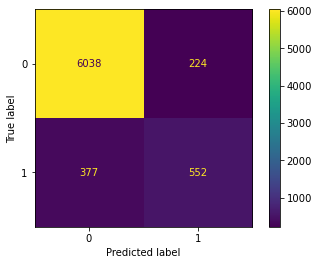

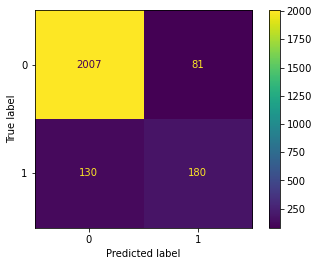

In [316]:
cat6_model = CatBoostClassifier(
                                random_seed=42,
                                iterations=100,
                                learning_rate=0.01,
                                boosting_type='Plain',
                                bootstrap_type='Bernoulli',
                                subsample=0.5,
                                one_hot_max_size=20,
                                rsm=0.5,
                                leaf_estimation_iterations=5,
                                max_ctr_complexity=1)

cat6_model.fit(
    X_train, y_train,
    
    verbose=False,
    plot=True)
#cat_features=cat_features,


model_evaluation(cat6_model, roc=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Train results
Accuracy: 0.9526
Precision: 0.8303
Recall: 0.7955
F1 Score: 0.8125
Test results
Accuracy: 0.9233
Precision: 0.7158
Recall: 0.6742
F1 Score: 0.6944


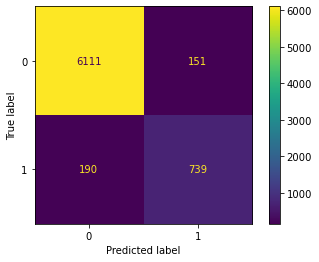

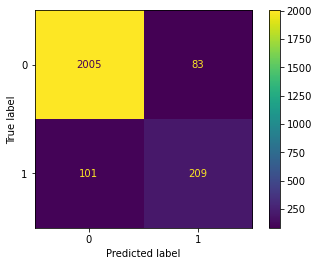

In [321]:
cat6_model = CatBoostClassifier(
                                random_seed=42,
                                iterations=1000,
                                learning_rate=0.01,
                                subsample=0.7,
                                rsm=0.5,
                                leaf_estimation_method='Gradient')

cat6_model.fit(
    X_train, y_train,
    
    verbose=False,
    plot=True)
#cat_features=cat_features,


model_evaluation(cat6_model, roc=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Train results
Accuracy: 0.9526
Precision: 0.8303
Recall: 0.7955
F1 Score: 0.8125
Test results
Accuracy: 0.9233
Precision: 0.7128
Recall: 0.6806
F1 Score: 0.6964


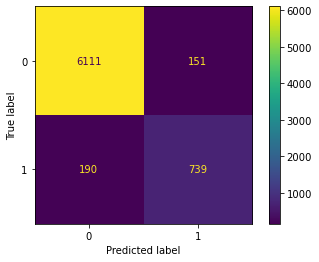

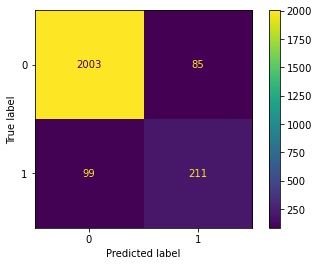

In [322]:
cat6_model = CatBoostClassifier(
                                random_seed=42,
                                iterations=1000,
                                learning_rate=0.01,
                                subsample=0.5,
                                rsm=0.5,
                                leaf_estimation_method='Gradient')

cat6_model.fit(X_train, y_train,
               verbose=False,
               plot=True)
#cat_features=cat_features,


model_evaluation(cat6_model, roc=False)

# Random Forest

Train results
Accuracy: 0.8956
Precision: 0.5533
Recall: 0.9946
F1 Score: 0.7110
Test results
Accuracy: 0.8807
Precision: 0.5208
Recall: 0.9710
F1 Score: 0.6779
roc_auc: 0.9191524533432208


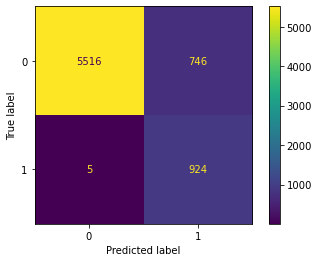

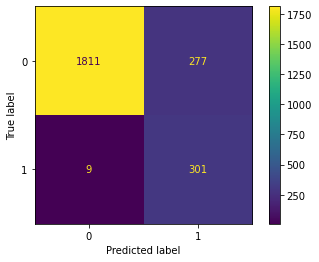

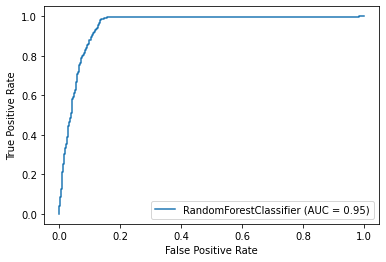

In [340]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42, 
                                  class_weight='balanced', 
                                  min_samples_split = 4, 
                                  criterion = 'gini', 
                                  max_depth = 8, 
                                  n_estimators = 100)

rf_model.fit(X_train, y_train)

model_evaluation(rf_model)                                  

In [341]:
rf_model_features = dict(zip(X_train.columns, rf_model.feature_importances_))
pd.DataFrame.from_dict(rf_model_features, orient='index').sort_values(by=0, ascending=False).head(15)

,0
num_threats,0.363949
agriculture_threat,0.197392
biological_threat,0.101279
invasive_threat,0.055699
endemic_breeding,0.051689
climate_change_threat,0.033604
natural_systems_threat,0.024479
res_comm_dev_threat,0.017684
BodyMass-Value,0.014302
transportation_threat,0.013169


Train results
Accuracy: 0.8968
Precision: 0.5564
Recall: 0.9935
F1 Score: 0.7133
Test results
Accuracy: 0.8824
Precision: 0.5243
Recall: 0.9742
F1 Score: 0.6817
roc_auc: 0.9214837473736249


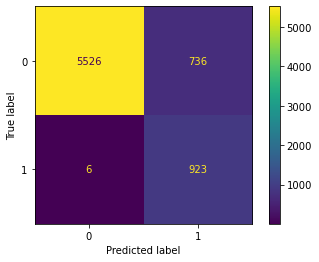

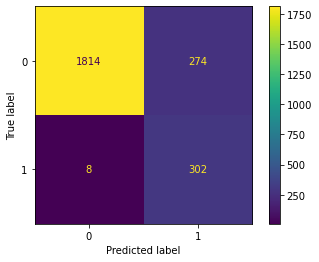

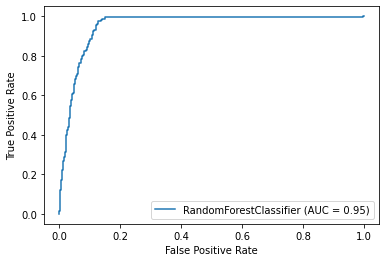

In [337]:
rf_model = RandomForestClassifier(random_state=42, 
                                  class_weight='balanced', 
                                  criterion = 'gini', 
                                  max_depth = 8, 
                                  n_estimators = 500)

rf_model.fit(X_train, y_train)

model_evaluation(rf_model)      

In [338]:
#important features
rf_model = dict(zip(X_train.columns, rf_model.feature_importances_))

pd.DataFrame.from_dict(rf_model, orient='index').sort_values(by=0, ascending=False).head(50)

,0
num_threats,0.283785
agriculture_threat,0.193670
biological_threat,0.136559
invasive_threat,0.064112
endemic_breeding,0.054878
climate_change_threat,0.037858
natural_systems_threat,0.030525
res_comm_dev_threat,0.028560
BodyMass-Value,0.015461
num_locations,0.014523


Train results
Accuracy: 0.9385
Precision: 0.8025
Recall: 0.6954
F1 Score: 0.7451
Test results
Accuracy: 0.9183
Precision: 0.7244
Recall: 0.5935
F1 Score: 0.6525
roc_auc: 0.7800117414411074


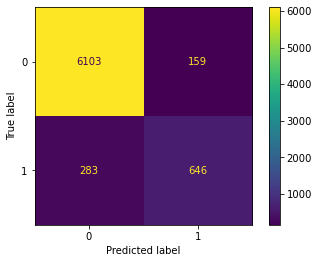

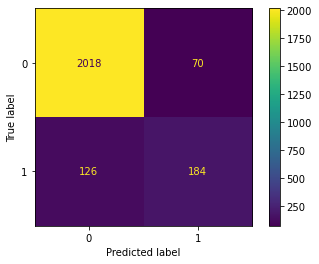

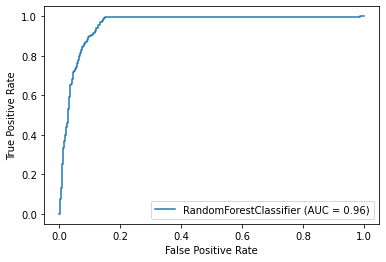

In [329]:
rf_model = RandomForestClassifier(random_state=42, 
                                  class_weight={0:1,1:1}, 
                                  criterion = 'gini', 
                                  max_depth = 7, 
                                  n_estimators = 500)

rf_model.fit(X_train, y_train)

model_evaluation(rf_model)  

Train results
Accuracy: 0.9419
Precision: 0.8150
Recall: 0.7115
F1 Score: 0.7598
Test results
Accuracy: 0.9195
Precision: 0.7259
Recall: 0.6065
F1 Score: 0.6608
roc_auc: 0.7862238907428006


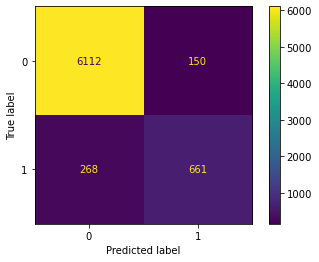

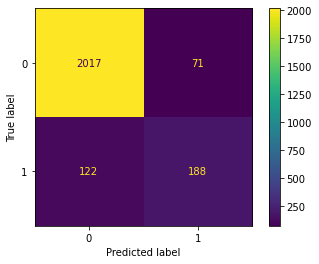

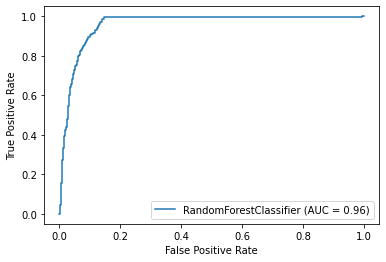

In [330]:
rf_model = RandomForestClassifier(random_state=42, 
                                  class_weight={0:1,1:1}, 
                                  criterion = 'gini', 
                                  max_depth = 7, 
                                  n_estimators = 500, 
                                  bootstrap=False)

rf_model.fit(X_train, y_train)

model_evaluation(rf_model)  

Train results
Accuracy: 0.9419
Precision: 0.8150
Recall: 0.7115
F1 Score: 0.7598
Test results
Accuracy: 0.9195
Precision: 0.7259
Recall: 0.6065
F1 Score: 0.6608


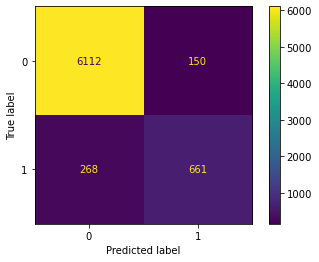

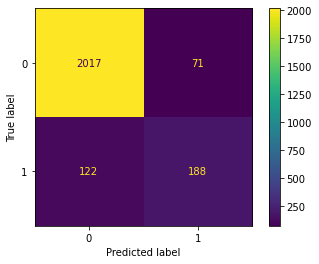

In [331]:
rf_model = RandomForestClassifier(random_state=42, 
                                  class_weight={0:1,1:1}, 
                                  criterion = 'gini', 
                                  max_depth = 7, 
                                  n_estimators = 500, 
                                  bootstrap=False)

rf_model.fit(X_train, y_train)

model_evaluation(rf_model, roc=False)  

Train results
Accuracy: 0.8910
Precision: 0.5428
Recall: 0.9892
F1 Score: 0.7010
Test results
Accuracy: 0.8786
Precision: 0.5161
Recall: 0.9839
F1 Score: 0.6770


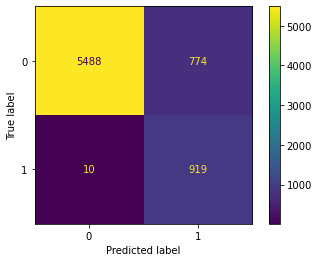

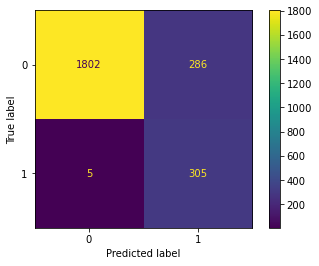

In [333]:
rf_model = RandomForestClassifier(random_state=42, 
                                  class_weight='balanced', 
                                  criterion = 'gini', 
                                  max_depth = 7, 
                                  n_estimators = 500, 
                                  bootstrap=True)

rf_model.fit(X_train, y_train)

model_evaluation(rf_model, roc=False) 